El objetivo de este proyecto es poder entrenar un modelo que sea capaz de reconocer las diferentes razas de perro

Importaremos las siguientes librerías que nos ayudarán a completar el proyecto

In [1]:
from fastai.vision.all import *
from fastdownload import download_url
from fastai.callback.mixup import CutMix

from torchvision.models import resnet18

from time import sleep
import matplotlib.pyplot as plt
import time
import gradio as gr

C:\Users\uai20\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from pathlib import Path
import shutil
import os

import random

Usaremos el conjunto de datos de Kaggle Dog Breeds que se encuentra descargado localmente en la siguiente dirección

In [13]:
dataset_path = Path(r"\\wsl.localhost\Ubuntu\home\uai2001\dog_breeds\images\Images")

output_path = Path(r"\\wsl.localhost\Ubuntu\home\uai2001\dog_classifier\dataset_split")

En esta dirección están las imágenes de cada raza de perro, pero no están separadas en bloques de entrenamiento, testeo y validación, por lo que vamos a tener que hacer esa separación de forma manual

Vamos a empezar con la separación manual de estas imágenes

In [ ]:
for folder in ["train", "test", "valid"]:
    (output_path/folder).mkdir(parents=True, exist_ok=True)

In [ ]:
# Obtener todas las carpetas de clases
class_folders = [d for d in dataset_path.iterdir() if d.is_dir()]

In [ ]:
# Iterar sobre cada clase y dividir imágenes en train, test y valid
for class_folder in class_folders:
    images = list(class_folder.glob("*.jpg"))  # Ajusta si hay PNG u otro formato
    random.shuffle(images)  # Mezclar imágenes aleatoriamente
    
    # Dividir en porcentajes
    num_images = len(images)
    train_split = int(num_images * 0.7)
    test_split = int(num_images * 0.2)

    train_images = images[:train_split]
    test_images = images[train_split:train_split + test_split]
    valid_images = images[train_split + test_split:]

    # Crear carpetas para cada clase dentro de train, test y valid
    for folder in ["train", "test", "valid"]:
        (output_path/folder/class_folder.name).mkdir(parents=True, exist_ok=True)

    # Mover imágenes a sus carpetas respectivas
    for img in train_images:
        shutil.move(str(img), str(output_path/"train"/class_folder.name/img.name))

    for img in test_images:
        shutil.move(str(img), str(output_path/"test"/class_folder.name/img.name))

    for img in valid_images:
        shutil.move(str(img), str(output_path/"valid"/class_folder.name/img.name))

print("✅ División completada. Imágenes organizadas en train, test y valid por clase.")

Ya teniendo nuestros datos separados podemos empezar el entrenamiento de nuestro modelo, pero como el conjunto de datos es muy grande y queremos tiempos de ejecución medianamente reducidos emplearemos el 20% de nuestros datos para realizar el entrenamiento

In [4]:
all_files = get_image_files(output_path/"train")

# Tomar solo el 20% de los datos
subset_size = int(len(all_files) * 0.2)
subset_files = all_files[:subset_size]

# Definir un nuevo DataBlock con menos datos
small_dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda p: subset_files,  # Usar solo el subconjunto de imágenes
    splitter=None,
    get_y=parent_label,
    item_tfms=[Resize(299, method='squish')],
    batch_tfms=[*aug_transforms(flip_vert=True, max_rotate=30, max_zoom=1.1), Normalize.from_stats(*imagenet_stats)]
).dataloaders(output_path/"train", bs=32)

Comprobamos que el DataSet esté correctamente definido

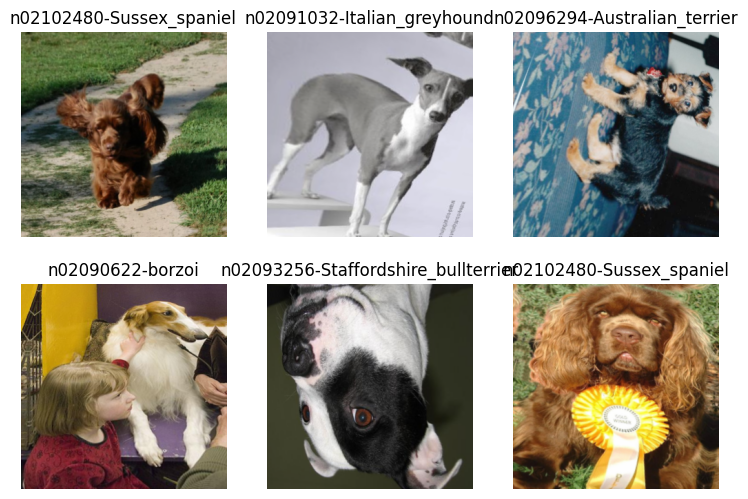

In [5]:
small_dls.show_batch(max_n=6)

Aplicaremos el método CutMix para evitar el sobreajuste y mejorar la precisión

In [6]:
learn = vision_learner(small_dls, resnet18, metrics=accuracy, loss_func=CrossEntropyLossFlat()).to_fp16()

learn.add_cb(CutMix(alpha=1.0))

In [7]:
learn.fine_tune(5, base_lr=1e-3, wd=1e-2)

C:\Users\uai20\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
C:\Users\uai20\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\cuda\amp\grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


epoch,train_loss,valid_loss,accuracy,time
0,3.843268,0.729045,0.780488,06:22


epoch,train_loss,valid_loss,accuracy,time
0,2.997015,0.523775,0.850174,11:58
1,2.651636,0.389592,0.885017,10:02
2,2.645359,0.415708,0.885017,10:18
3,2.598623,0.378955,0.898955,10:04
4,2.437718,0.384304,0.898955,09:27


In [8]:
learn = vision_learner(small_dls, resnet18, metrics=accuracy).to_fp16()

learn.fit_one_cycle(3, lr_max=slice(1e-5, 1e-3), wd=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.619407,0.456011,0.857143,07:28
1,1.459115,0.318562,0.897213,07:25
2,1.092493,0.302343,0.888502,07:17


In [9]:
learn.export("dog_breed_model_1.pkl")

Quiero verificar la precisión del modelo mediante el data set de tester 

In [8]:
learn = load_learner("dog_breed_model_1.pkl")

In [17]:
test_path = Path(r"\\wsl.localhost\Ubuntu\home\uai2001\dog_classifier\dataset_split\test")

In [10]:
# Obtener todas las imágenes de test
all_test_images = get_image_files(test_path)
print(all_test_images)


[Path('//wsl.localhost/Ubuntu/home/uai2001/dog_classifier/dataset_split/test/n02095889-Sealyham_terrier/n02095889_4116.jpg'), Path('//wsl.localhost/Ubuntu/home/uai2001/dog_classifier/dataset_split/test/n02095889-Sealyham_terrier/n02095889_4507.jpg'), Path('//wsl.localhost/Ubuntu/home/uai2001/dog_classifier/dataset_split/test/n02095889-Sealyham_terrier/n02095889_4951.jpg'), Path('//wsl.localhost/Ubuntu/home/uai2001/dog_classifier/dataset_split/test/n02095889-Sealyham_terrier/n02095889_4522.jpg'), Path('//wsl.localhost/Ubuntu/home/uai2001/dog_classifier/dataset_split/test/n02095889-Sealyham_terrier/n02095889_1328.jpg'), Path('//wsl.localhost/Ubuntu/home/uai2001/dog_classifier/dataset_split/test/n02095889-Sealyham_terrier/n02095889_1736.jpg'), Path('//wsl.localhost/Ubuntu/home/uai2001/dog_classifier/dataset_split/test/n02095889-Sealyham_terrier/n02095889_2925.jpg'), Path('//wsl.localhost/Ubuntu/home/uai2001/dog_classifier/dataset_split/test/n02095889-Sealyham_terrier/n02095889_4039.jpg'),

In [11]:
# Seleccionar una imagen aleatoria
random_image_path = random.choice(all_test_images)
random_image_path

Path('//wsl.localhost/Ubuntu/home/uai2001/dog_classifier/dataset_split/test/n02097658-silky_terrier/n02097658_633.jpg')

In [12]:
# Cargar la imagen
img = PILImage.create(random_image_path)

In [14]:
# Hacer la predicción
pred, pred_idx, probs = learn.predict(img)

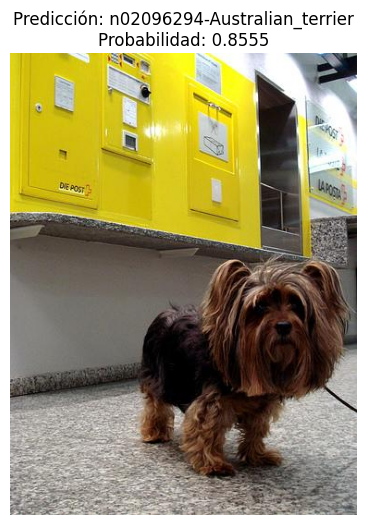

In [15]:
# Mostrar la imagen y la predicción
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.axis("off")
plt.title(f"Predicción: {pred}\nProbabilidad: {probs[pred_idx]:.4f}")
plt.show()

In [16]:
# Obtener las 5 razas con mayor probabilidad
top_5_probs, top_5_idxs = probs.topk(5)
top_5_labels = [learn.dls.vocab[i] for i in top_5_idxs]

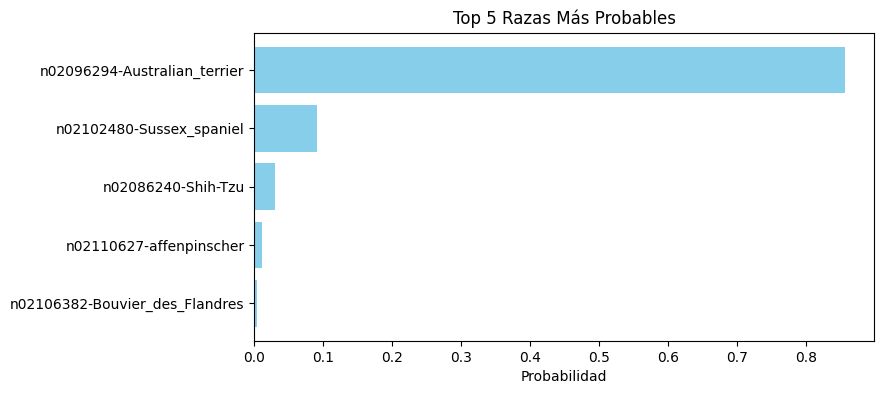

In [17]:
# Graficar las probabilidades
plt.figure(figsize=(8,4))
plt.barh(top_5_labels[::-1], top_5_probs.detach().numpy()[::-1], color='skyblue')
plt.xlabel("Probabilidad")
plt.title("Top 5 Razas Más Probables")
plt.show()

Ahora lo haremos con 100 imágenes, haremos la media de su exactitud

In [29]:
all_test_images = get_image_files(test_path, recurse=True)

In [30]:
random_images = random.sample(all_test_images, min(100, len(all_test_images)))

In [31]:
correct_predictions = []

In [21]:
for img_path in random_images:
    # Cargar la imagen
    img = PILImage.create(img_path)
    
    # Hacer la predicción
    pred, pred_idx, probs = learn.predict(img)
    
    # Obtener la etiqueta real
    actual_label = img_path.parent.name
    
    # Verificar si la predicción es correcta
    is_correct = pred == actual_label
    correct_predictions.append(is_correct)

In [22]:
# Calcular la precisión promedio
accuracy1 = sum(correct_predictions) / len(correct_predictions)
print(f"Precisión del modelo en 100 imágenes: {accuracy1:.2%}")

Precisión del modelo en 100 imágenes: 20.00%


Osea más bien triste, pero no nos desanimemos de aquí para adelante 

Por lo que haremos un análisis de errores, al haber separado manualmente el DataBlock puse "splitter=None" por error, por lo que he de volver a generar el DataBlock y entrenar el modelo

In [23]:
all_files = get_image_files(output_path/"train")

# Tomar solo el 20% de los datos
subset_size = int(len(all_files) * 0.2)
subset_files = all_files[:subset_size]

# Definir un nuevo DataBlock con menos datos
small_dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda p: subset_files,  # Usar solo el subconjunto de imágenes
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(299, method='squish')],
    batch_tfms=[*aug_transforms(flip_vert=True, max_rotate=30, max_zoom=1.1), Normalize.from_stats(*imagenet_stats)]
).dataloaders(output_path/"train", bs=32)

In [3]:
from fastai.metrics import accuracy

In [26]:
learn = vision_learner(small_dls, resnet18, metrics=accuracy).to_fp16()

learn.fit_one_cycle(3, lr_max=slice(1e-5, 1e-3), wd=1e-2)

C:\Users\uai20\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
C:\Users\uai20\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\cuda\amp\grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


epoch,train_loss,valid_loss,accuracy,time
0,2.550462,0.471633,0.850174,06:27
1,1.412354,0.360197,0.883275,07:26
2,1.046276,0.327836,0.891986,10:42


In [27]:
correct_predictions_1 = []

In [28]:
for img_path in random_images:
    # Cargar la imagen
    img = PILImage.create(img_path)
    
    # Hacer la predicción
    pred, pred_idx, probs = learn.predict(img)
    
    # Obtener la etiqueta real
    actual_label = img_path.parent.name
    
    # Verificar si la predicción es correcta
    is_correct = pred == actual_label
    correct_predictions_1.append(is_correct)

C:\Users\uai20\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
C:\Users\uai20\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\cuda\amp\grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [29]:
# Calcular la precisión promedio
accuracy2 = sum(correct_predictions) / len(correct_predictions)
print(f"Precisión del modelo en 100 imágenes: {accuracy2:.2%}")

Precisión del modelo en 100 imágenes: 20.00%


C:\Users\uai20\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
C:\Users\uai20\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\cuda\amp\grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


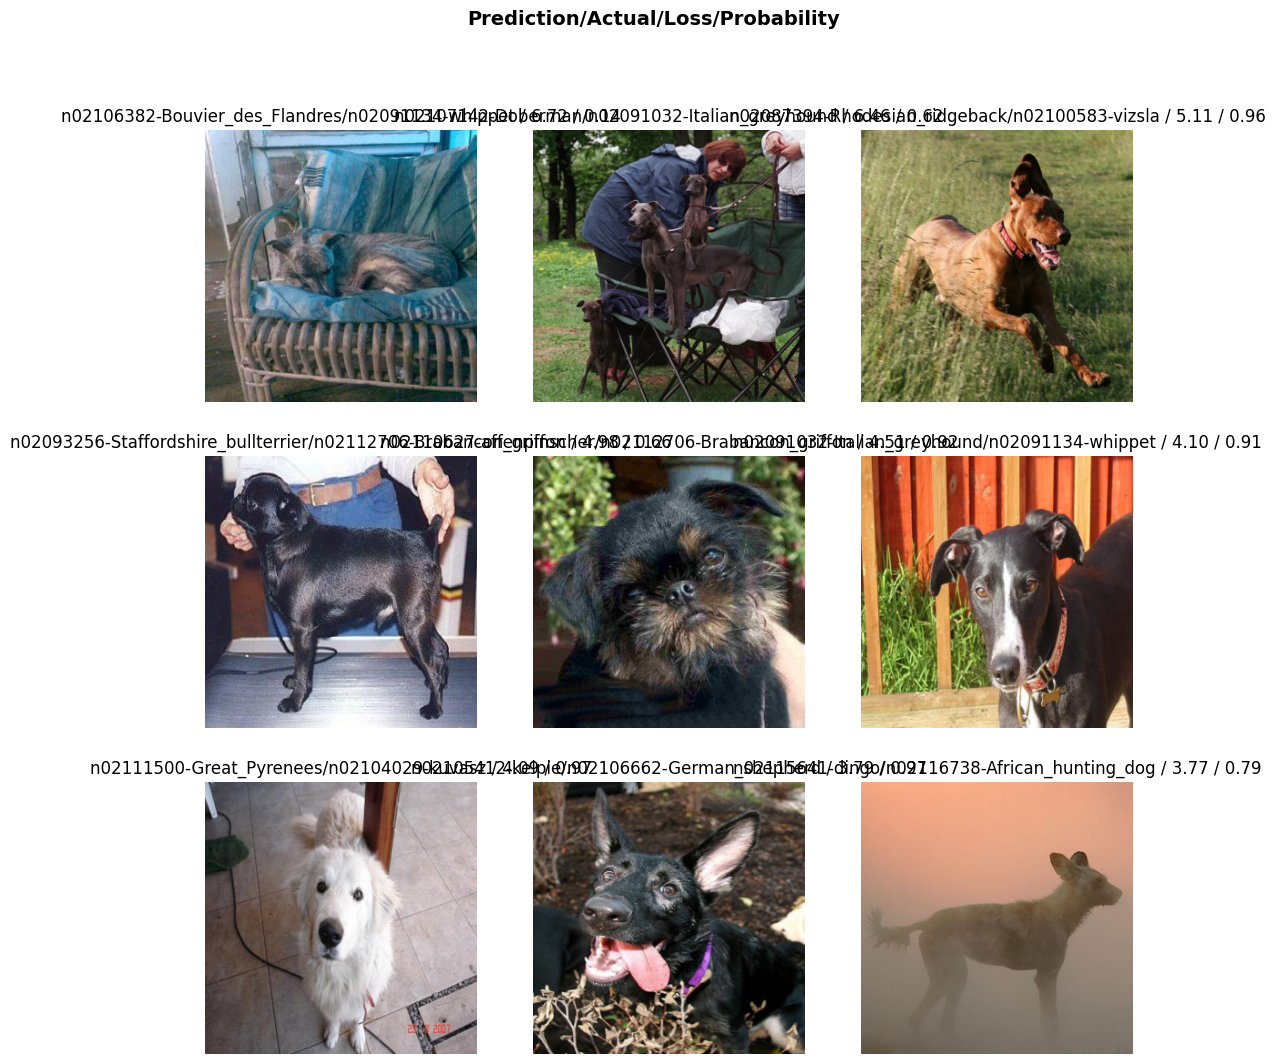

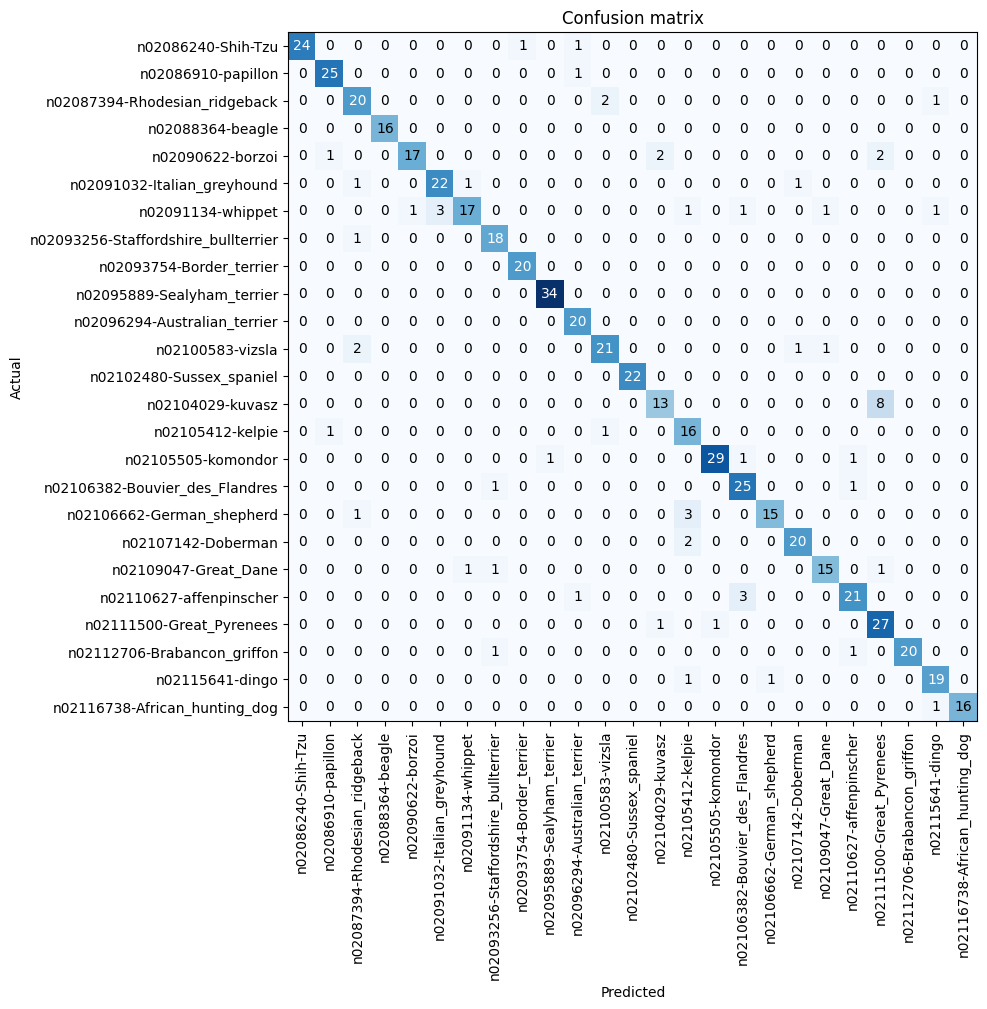

In [30]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(12,12))
interp.plot_confusion_matrix(figsize=(10,10), dpi=100)


In [31]:
learn.export("dog_breed_model_2.pkl")

Quiero verificar que ninguna clase está sobre representada

In [4]:
from collections import Counter

In [7]:
data_path = output_path/"train"

# Contar el número de imágenes por clase
class_counts = {cls.name: len(list(cls.glob('*'))) for cls in data_path.iterdir() if cls.is_dir()}

# Mostrar el conteo de imágenes por clase
for class_name, count in class_counts.items():
    print(f"Clase: {class_name}, Cantidad de imágenes: {count}")

# Verificar si todas las clases tienen el mismo número de imágenes
counts = list(class_counts.values())
if len(set(counts)) == 1:
    print("\n✅ Todas las clases tienen la misma cantidad de imágenes.")
else:
    print("\n⚠️ Las clases tienen cantidades desiguales de imágenes.")
    print(f"Rango de imágenes por clase: {min(counts)} - {max(counts)}")

Clase: n02095889-Sealyham_terrier, Cantidad de imágenes: 141
Clase: n02102480-Sussex_spaniel, Cantidad de imágenes: 105
Clase: n02090622-borzoi, Cantidad de imágenes: 105
Clase: n02116738-African_hunting_dog, Cantidad de imágenes: 118
Clase: n02106382-Bouvier_des_Flandres, Cantidad de imágenes: 105
Clase: n02110627-affenpinscher, Cantidad de imágenes: 105
Clase: n02115641-dingo, Cantidad de imágenes: 109
Clase: n02086910-papillon, Cantidad de imágenes: 137
Clase: n02096294-Australian_terrier, Cantidad de imágenes: 137
Clase: n02086240-Shih-Tzu, Cantidad de imágenes: 149
Clase: n02091032-Italian_greyhound, Cantidad de imágenes: 127
Clase: n02104029-kuvasz, Cantidad de imágenes: 105
Clase: n02100583-vizsla, Cantidad de imágenes: 107
Clase: n02087394-Rhodesian_ridgeback, Cantidad de imágenes: 120
Clase: n02093754-Border_terrier, Cantidad de imágenes: 120
Clase: n02105505-komondor, Cantidad de imágenes: 107
Clase: n02091134-whippet, Cantidad de imágenes: 130
Clase: n02109047-Great_Dane, Ca

In [5]:
import numpy as np

In [9]:
# Calcular el promedio de imágenes por clase
avg_count = np.mean(list(class_counts.values()))

# Obtener clases con menos imágenes que el promedio
underrepresented_classes = {cls: count for cls, count in class_counts.items() if count < avg_count}

# Mostrar resultados
print(f"Promedio de imágenes por clase: {avg_count:.2f}\n")
print("Clases con menos imágenes que el promedio:")
for cls, count in underrepresented_classes.items():
    print(f"Clase: {cls}, Cantidad de imágenes: {count}")

Promedio de imágenes por clase: 118.64

Clases con menos imágenes que el promedio:
Clase: n02102480-Sussex_spaniel, Cantidad de imágenes: 105
Clase: n02090622-borzoi, Cantidad de imágenes: 105
Clase: n02116738-African_hunting_dog, Cantidad de imágenes: 118
Clase: n02106382-Bouvier_des_Flandres, Cantidad de imágenes: 105
Clase: n02110627-affenpinscher, Cantidad de imágenes: 105
Clase: n02115641-dingo, Cantidad de imágenes: 109
Clase: n02104029-kuvasz, Cantidad de imágenes: 105
Clase: n02100583-vizsla, Cantidad de imágenes: 107
Clase: n02105505-komondor, Cantidad de imágenes: 107
Clase: n02109047-Great_Dane, Cantidad de imágenes: 109
Clase: n02093256-Staffordshire_bullterrier, Cantidad de imágenes: 108
Clase: n02107142-Doberman, Cantidad de imágenes: 105
Clase: n02106662-German_shepherd, Cantidad de imágenes: 106
Clase: n02105412-kelpie, Cantidad de imágenes: 107
Clase: n02112706-Brabancon_griffon, Cantidad de imágenes: 107
Clase: n02101388-Brittany_spaniel, Cantidad de imágenes: 106
Cla

In [6]:
import shutil
import torchvision.transforms as T

from torchvision import transforms 
from collections import defaultdict
from PIL import Image

In [20]:
learn = load_learner("dog_breed_model_2.pkl")

In [14]:
small_dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(299, method='squish')],
    batch_tfms=[*aug_transforms(flip_vert=True, max_rotate=30, max_zoom=1.1), Normalize.from_stats(*imagenet_stats)]
).dataloaders(output_path/"train", bs=32)

In [25]:
learn = vision_learner(small_dls, resnet18, metrics=accuracy).to_fp16()

learn.fit_one_cycle(5, lr_max=slice(1e-5, 1e-3), wd=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,3.278623,1.365295,0.601533,32:20
1,2.026346,0.855909,0.733891,35:25
2,1.700598,0.736985,0.762452,35:14
3,1.510480,0.687811,0.780216,35:17
4,1.454203,0.687306,0.780564,35:19


In [27]:
learn = vision_learner(small_dls, resnet18, metrics=accuracy).to_fp16()

learn.fine_tune(3)

epoch,train_loss,valid_loss,accuracy,time
0,2.504911,1.079030,0.677464,26:43


epoch,train_loss,valid_loss,accuracy,time
0,1.834040,0.975966,0.701846,34:52
1,1.506858,0.811687,0.743295,44:32
2,1.189051,0.739099,0.767677,44:18


In [32]:
for img_path in random_images:
    # Cargar la imagen
    img = PILImage.create(img_path)
    
    # Hacer la predicción
    pred, pred_idx, probs = learn.predict(img)
    
    # Obtener la etiqueta real
    actual_label = img_path.parent.name
    
    # Verificar si la predicción es correcta
    is_correct = pred == actual_label
    correct_predictions.append(is_correct)

In [33]:
# Calcular la precisión promedio
accuracy2 = sum(correct_predictions) / len(correct_predictions)
print(f"Precisión del modelo en 100 imágenes: {accuracy2:.2%}")

Precisión del modelo en 100 imágenes: 75.00%


In [34]:
learn.unfreeze()
learn.fit_one_cycle(3, lr_max=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,1.157895,0.719437,0.770812,39:45
1,1.063162,0.707759,0.774643,44:36
2,1.059336,0.697454,0.786137,42:49


In [44]:
random_images = random.sample(all_test_images, min(100, len(all_test_images)))

In [45]:
correct_predictions = []

In [46]:
for img_path in random_images:
    # Cargar la imagen
    img = PILImage.create(img_path)
    
    # Hacer la predicción
    pred, pred_idx, probs = learn.predict(img)
    
    # Obtener la etiqueta real
    actual_label = img_path.parent.name
    
    # Verificar si la predicción es correcta
    is_correct = pred == actual_label
    correct_predictions.append(is_correct)

In [47]:
# Calcular la precisión promedio
accuracy2 = sum(correct_predictions) / len(correct_predictions)
print(f"Precisión del modelo en 100 imágenes: {accuracy2:.2%}")

Precisión del modelo en 100 imágenes: 80.00%


In [48]:
learn.export("dog_breed_model_3.pkl")

In [8]:
learn =load_learner("dog_breed_model_3.pkl")

In [9]:
valid_path = Path(r"\\wsl.localhost\Ubuntu\home\uai2001\dog_classifier\dataset_split\valid")

In [19]:
valid_dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(299, method='squish')],
    batch_tfms=[*aug_transforms(flip_vert=True, max_rotate=30, max_zoom=1.1), Normalize.from_stats(*imagenet_stats)]
).dataloaders(output_path/"valid", bs=32)

In [22]:
accuracy_value = learn.validate(dl=valid_dls[1])[1]

print(f"Precisión en el conjunto de validación: {accuracy_value:.4f}")

Precisión en el conjunto de validación: 0.8209
